# Atelier GSF-2101 - Gestion du portefeuille

## Optimisation de portefeuille 

### Explication Détaillée du Code

1. **Importation des Bibliothèques**
   - **`numpy`** : Utilisé pour des opérations numériques avancées, comme la manipulation de tableaux et le calcul de statistiques.
   - **`pandas`** : Permet de travailler avec des données sous forme de tableaux (DataFrames), facilitant la gestion et l'analyse des données financières.
   - **`yfinance`** : Une bibliothèque pour télécharger des données financières historiques depuis Yahoo Finance, ce qui est essentiel pour obtenir les prix des actifs.
   - **`cvxpy`** : Utilisée pour formuler et résoudre des problèmes d'optimisation convexes, essentiels dans le calcul des portefeuilles optimaux.
   - **`matplotlib.pyplot`** : Bibliothèque de visualisation qui permet de tracer des graphiques et des figures pour illustrer les résultats de l'optimisation.

2. **Classe `PortfolioOptimizer`**
   - **Initialisation (`__init__`)** :
     - **Paramètres** :
       - `tickers` : Liste de symboles boursiers (ex : ['AAPL', 'MSFT']).
       - `period` : La durée sur laquelle les données historiques seront extraites (ex : '1y' pour un an).
       - `risk_free_rate` : Le taux sans risque (généralement basé sur les rendements des obligations d'État).
     - **Calcul du Taux Sans Risque Journalier** : Le taux sans risque est converti en un taux journalier en utilisant une approximation basée sur le nombre de jours de marché (252 jours par an).
     - **Attributs Initiaux** : Plusieurs attributs sont définis pour stocker les données de prix, les rendements, la moyenne des rendements et la matrice de covariance.

3. **Méthode `load_data`**
   - **Téléchargement des Données** : Utilise `yfinance` pour récupérer les prix ajustés des actifs sur la période définie.
   - **Calcul des Rendements** : Les rendements quotidiens sont calculés en prenant la variation proportionnelle des prix d'un jour à l'autre.
   - **Statistiques** :
     - **Moyenne des Rendements** : Calcule la moyenne des rendements quotidiens pour chaque actif.
     - **Matrice de Covariance** : Évalue la variance et la covariance des rendements, ce qui est essentiel pour l'analyse du risque.

4. **Méthode `optimize_portfolio`**
   - **Objectif de l'Optimisation** : 
     - Permet de choisir un type d'optimisation basé sur l'objectif (minimiser la variance, maximiser le rendement, etc.).
   - **Variables d'Optimisation** : Les poids des actifs dans le portefeuille sont définis comme des variables à optimiser.
   - **Contraintes** : 
     - La somme des poids doit être égale à 1 (100% du portefeuille).
     - Les poids doivent être non négatifs (pas de vente à découvert).
   - **Optimisation** :
     - Selon le type d'optimisation choisi, l'objectif est formulé pour minimiser ou maximiser une fonction (variance, rendement, ratio de Sharpe).
     - La méthode `solve()` de `cvxpy` est utilisée pour résoudre le problème d'optimisation et obtenir les poids optimaux.

5. **Optimisation du Ratio de Sharpe (`optimize_sharpe_ratio`)**
   - **Définition du Ratio de Sharpe** : Mesure la performance d'un investissement en tenant compte de son risque. Il est calculé comme suit :
     \[
     \text{Sharpe Ratio} = \frac{\text{Rendement du portefeuille} - \text{Taux sans risque}}{\text{Écart-type des rendements}}
     \]
   - **Boucle sur les Rendements Cibles** : Pour chaque rendement cible, un problème d'optimisation est résolu pour minimiser la variance tout en atteignant ce rendement.
   - **Comparaison des Ratios de Sharpe** : Le meilleur ratio de Sharpe est stocké avec les poids correspondants.

6. **Calcul de la Frontière Efficiente (`calculate_efficient_frontier`)**
   - **Définition de la Frontière Efficiente** : C'est la courbe qui montre le meilleur rendement possible pour chaque niveau de risque.
   - **Calcul** : Pour un certain nombre de points cibles de rendements, le portefeuille est optimisé et les résultats (rendement et variance) sont stockés.

7. **Visualisation des Résultats**
   - **`plot_efficient_frontier`** : Cette méthode crée un graphique qui affiche la frontière efficiente ainsi que les portefeuilles optimaux, incluant des marqueurs pour le portefeuille de variance minimale (GMV) et le portefeuille avec le meilleur ratio de Sharpe.
   - **Graphiques Additionnels** : Les portefeuilles optimaux selon des contraintes spécifiques (comme le rendement cible) sont également visualisés.

8. **Matrice de Corrélation (`plot_correlation_matrix`)**
   - **Heatmap** : Crée une visualisation de la matrice de corrélation entre les actifs, ce qui est utile pour comprendre les relations entre les rendements des différents actifs.

9. **Fonction Principale (`main`)**
   - **Configuration des Paramètres** : Définit les symboles boursiers, les cibles de rendement et de variance, et le taux sans risque.
   - **Création de l'Optimiseur** : Instancie la classe `PortfolioOptimizer` avec les paramètres spécifiés.
   - **Calcul et Affichage des Portefeuilles** : Optimise différents portefeuilles, affiche la matrice de corrélation, la frontière efficiente et les métriques des portefeuilles.



In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import cvxpy as cp
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

class PortfolioOptimizer:
    def __init__(self, tickers: List[str], period: str = '1y', risk_free_rate: float = 0.03):
        """
        Initialise l'optimiseur de portefeuille
        :param tickers: Liste des symboles boursiers
        :param period: Période d'historique ('1y', '2y', etc.)
        :param risk_free_rate: Taux sans risque annuel
        """
        self.tickers = tickers
        self.period = period
        self.risk_free_rate = risk_free_rate  # Taux annuel
        self.daily_risk_free_rate = (1 + risk_free_rate) ** (1/252) - 1  # Conversion en taux journalier
        self.data = None
        self.returns = None
        self.mean_returns = None
        self.cov_matrix = None
        self.load_data()
        
    def load_data(self):
        """Charge les données historiques et calcule les rendements"""
        self.data = yf.download(self.tickers, period=self.period)['Adj Close']
        self.returns = self.data.pct_change().dropna()
        self.mean_returns = self.returns.mean()
        self.cov_matrix = self.returns.cov()

    def optimize_portfolio(self, optimization_type: str, target_value: float = None) -> Dict:
        """
        Optimise le portefeuille selon différents critères
        :param optimization_type: 'gmv', 'min_var', 'max_return', 'max_sharpe'
        :param target_value: Valeur cible pour le rendement ou la variance
        :return: Dictionnaire contenant les poids optimaux et les métriques
        """
        num_assets = len(self.mean_returns)
        w = cp.Variable(num_assets)
        portfolio_variance = cp.quad_form(w, self.cov_matrix)
        portfolio_return = self.mean_returns.values @ w
        
        constraints = [cp.sum(w) == 1, w >= 0]  # Contrainte de non-négativité
        
        if optimization_type == 'gmv':
            objective = cp.Minimize(portfolio_variance)
        elif optimization_type == 'min_var':
            objective = cp.Minimize(portfolio_variance)
            constraints += [portfolio_return >= target_value]
        elif optimization_type == 'max_return':
            objective = cp.Maximize(portfolio_return)
            constraints += [portfolio_variance <= target_value]
        elif optimization_type == 'max_sharpe':
            return self.optimize_sharpe_ratio()
            
        prob = cp.Problem(objective, constraints)
        prob.solve()
        
        weights = w.value
        return {
            'weights': pd.Series(weights, index=self.mean_returns.index),
            'return': float(self.mean_returns.values @ weights),
            'variance': float(weights.T @ self.cov_matrix.values @ weights),
            'sharpe': self.calculate_sharpe_ratio(weights),
            'volatility': float(np.sqrt(weights.T @ self.cov_matrix.values @ weights))
        }

    def optimize_sharpe_ratio(self) -> Dict:
        """
        Optimise le ratio de Sharpe du portefeuille en utilisant une approche convexe
        """
        num_assets = len(self.mean_returns)
        w = cp.Variable(num_assets)
        
        portfolio_return = self.mean_returns.values @ w
        portfolio_variance = cp.quad_form(w, self.cov_matrix)
        
        constraints = [
            cp.sum(w) == 1,
            w >= 0,
        ]
        
        risk_free_return = self.daily_risk_free_rate
        best_sharpe = -np.inf
        best_weights = None
        best_metrics = None
        
        target_returns = np.linspace(self.mean_returns.min(), self.mean_returns.max(), 100)
        
        for target_return in target_returns:
            constraints_temp = constraints + [portfolio_return >= target_return]
            objective = cp.Minimize(portfolio_variance)
            prob = cp.Problem(objective, constraints_temp)
            
            try:
                prob.solve()
                
                if w.value is not None:
                    portfolio_ret = self.mean_returns.values @ w.value
                    portfolio_std = np.sqrt(w.value.T @ self.cov_matrix.values @ w.value)
                    sharpe = (portfolio_ret - risk_free_return) / portfolio_std
                    
                    if sharpe > best_sharpe:
                        best_sharpe = sharpe
                        best_weights = w.value
                        best_metrics = {
                            'return': portfolio_ret,
                            'variance': portfolio_std**2,
                            'sharpe': sharpe,
                            'volatility': portfolio_std
                        }
            except:
                continue
        
        if best_weights is None:
            raise ValueError("Impossible de trouver une solution optimale pour le ratio de Sharpe")
        
        return {
            'weights': pd.Series(best_weights, index=self.mean_returns.index),
            'return': best_metrics['return'],
            'variance': best_metrics['variance'],
            'sharpe': best_metrics['sharpe'],
            'volatility': best_metrics['volatility']
        }

    def calculate_sharpe_ratio(self, weights: np.ndarray) -> float:
        """
        Calcule le ratio de Sharpe pour un ensemble de poids donné
        """
        portfolio_return = self.mean_returns.values @ weights
        portfolio_std = np.sqrt(weights.T @ self.cov_matrix.values @ weights)
        return (portfolio_return - self.daily_risk_free_rate) / portfolio_std

    def calculate_efficient_frontier(self, num_points: int = 50) -> pd.DataFrame:
        """
        Calcule la frontière efficiente
        """
        target_returns = np.linspace(self.mean_returns.min(), self.mean_returns.max(), num_points)
        efficient_portfolios = []
        
        for tr in target_returns:
            result = self.optimize_portfolio('min_var', tr)
            efficient_portfolios.append({
                'Return': result['return'],
                'Variance': result['variance']
            })
            
        return pd.DataFrame(efficient_portfolios)

    def plot_efficient_frontier(self, target_return: float = None, target_variance: float = None):
        """
        Trace la frontière efficiente et les portefeuilles optimaux
        """
        plt.figure(figsize=(12, 8))
        
        ef = self.calculate_efficient_frontier()
        plt.plot(np.sqrt(ef['Variance']), ef['Return'], 'b--', label='Frontière Efficiente')
        
        gmv = self.optimize_portfolio('gmv')
        plt.scatter(np.sqrt(gmv['variance']), gmv['return'], 
                   color='red', marker='*', s=200, label=f'GMV (Sharpe: {gmv["sharpe"]:.2f})')
        
        max_sharpe = self.optimize_portfolio('max_sharpe')
        plt.scatter(np.sqrt(max_sharpe['variance']), max_sharpe['return'],
                   color='gold', marker='D', s=200, label=f'Max Sharpe ({max_sharpe["sharpe"]:.2f})')
        
        if target_return is not None:
            min_var = self.optimize_portfolio('min_var', target_return)
            plt.scatter(np.sqrt(min_var['variance']), min_var['return'],
                       color='green', marker='o', s=100, 
                       label=f'Min Var (Sharpe: {min_var["sharpe"]:.2f})')
            
        if target_variance is not None:
            max_ret = self.optimize_portfolio('max_return', target_variance)
            plt.scatter(np.sqrt(max_ret['variance']), max_ret['return'],
                       color='purple', marker='X', s=100, 
                       label=f'Max Return (Sharpe: {max_ret["sharpe"]:.2f})')
        
        plt.xlabel('Volatilité (Écart-type)')
        plt.ylabel('Rendement Espéré')
        plt.title('Frontière Efficiente de Markowitz avec Ratio de Sharpe')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_portfolio_metrics(self, portfolio_results: Dict[str, Dict]):
        """
        Visualise les métriques des différents portefeuilles
        """
        # Création d'un DataFrame avec les métriques
        metrics_data = {
            name: {
                'Return': data['return'] * 252,  # Annualisé
                'Volatility': data['volatility'] * np.sqrt(252),  # Annualisée
                'Sharpe Ratio': data['sharpe']
            }
            for name, data in portfolio_results.items()
        }
        metrics_df = pd.DataFrame(metrics_data).T
        
        # Création de la figure avec sous-graphiques
        fig = plt.figure(figsize=(15, 10))
        
        # 1. Graphique des rendements et volatilités
        ax1 = plt.subplot(221)
        metrics_df[['Return', 'Volatility']].plot(kind='bar', ax=ax1)
        ax1.set_title('Rendement et Volatilité Annualisés par Stratégie')
        ax1.set_ylabel('Pourcentage (%)')
        plt.xticks(rotation=45)
        
        # 2. Graphique du ratio de Sharpe
        ax2 = plt.subplot(222)
        metrics_df['Sharpe Ratio'].plot(kind='bar', ax=ax2, color='green')
        ax2.set_title('Ratio de Sharpe par Stratégie')
        plt.xticks(rotation=45)
        
        # 3. Graphique des allocations
        ax3 = plt.subplot(212)
        weights_data = pd.DataFrame({
            name: data['weights']
            for name, data in portfolio_results.items()
        })
        
        # Création d'un graphique à barres empilées pour les allocations
        weights_data.plot(kind='bar', stacked=True, ax=ax3)
        ax3.set_title('Allocation des Actifs par Stratégie')
        ax3.set_ylabel('Poids (%)')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Affichage des métriques détaillées
        print("\nMétriques détaillées des portefeuilles:")
        print(metrics_df.round(4))
        
        # Affichage des allocations détaillées
        print("\nAllocations détaillées des portefeuilles:")
        print(weights_data.round(4))

    def plot_correlation_matrix(self):
        """
        Affiche la matrice de corrélation des actifs
        """
        plt.figure(figsize=(10, 8))
        correlation_matrix = self.returns.corr()
        
        # Création de la heatmap
        plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
        plt.colorbar()
        
        # Ajout des annotations
        for i in range(len(correlation_matrix)):
            for j in range(len(correlation_matrix)):
                plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                        ha='center', va='center')
        
        # Configuration des ticks
        plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
        plt.yticks(range(len(correlation_matrix)), correlation_matrix.index)
        
        plt.title('Matrice de Corrélation des Actifs')
        plt.tight_layout()
        plt.show()


[*********************100%***********************]  7 of 7 completed


Affichage de la matrice de corrélation des actifs:


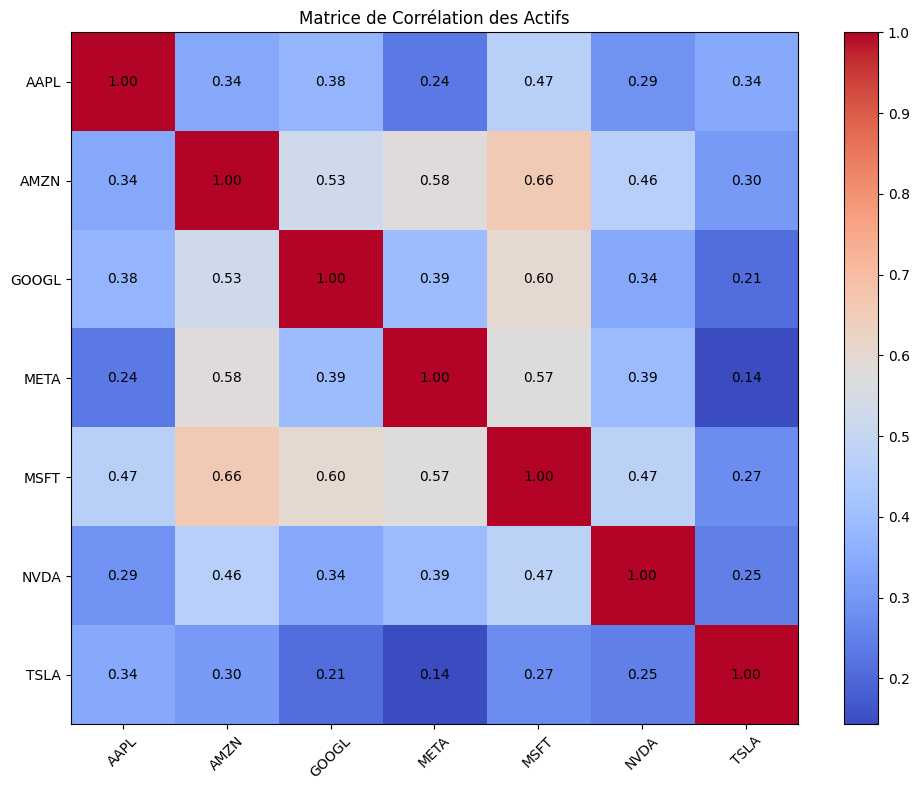


Affichage de la frontière efficiente:


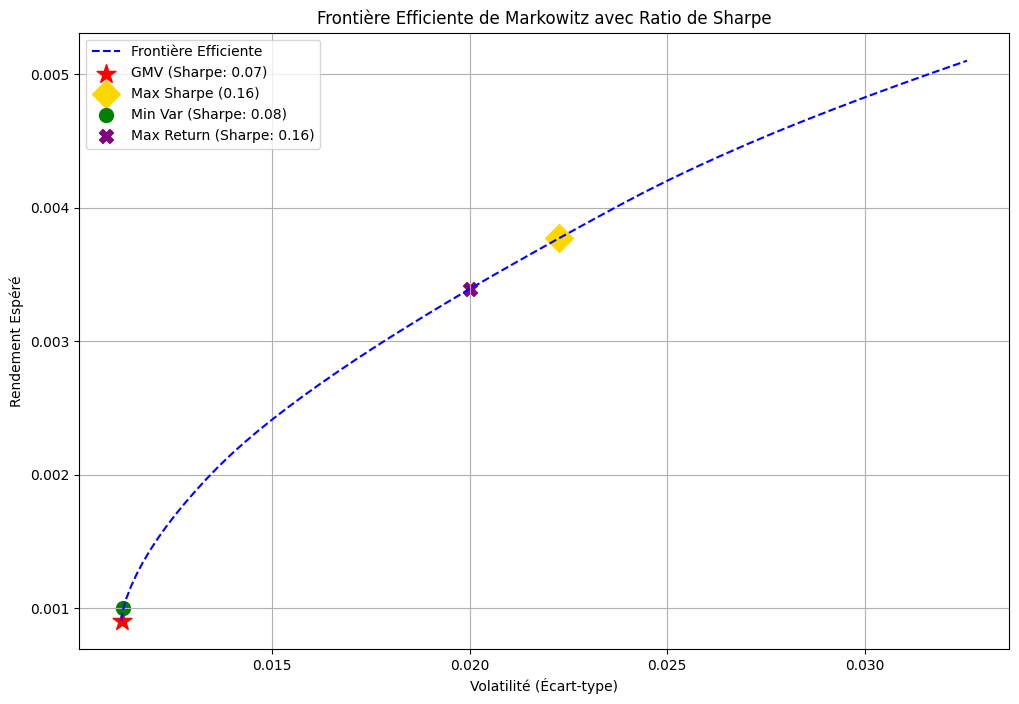


Affichage des métriques des portefeuilles:


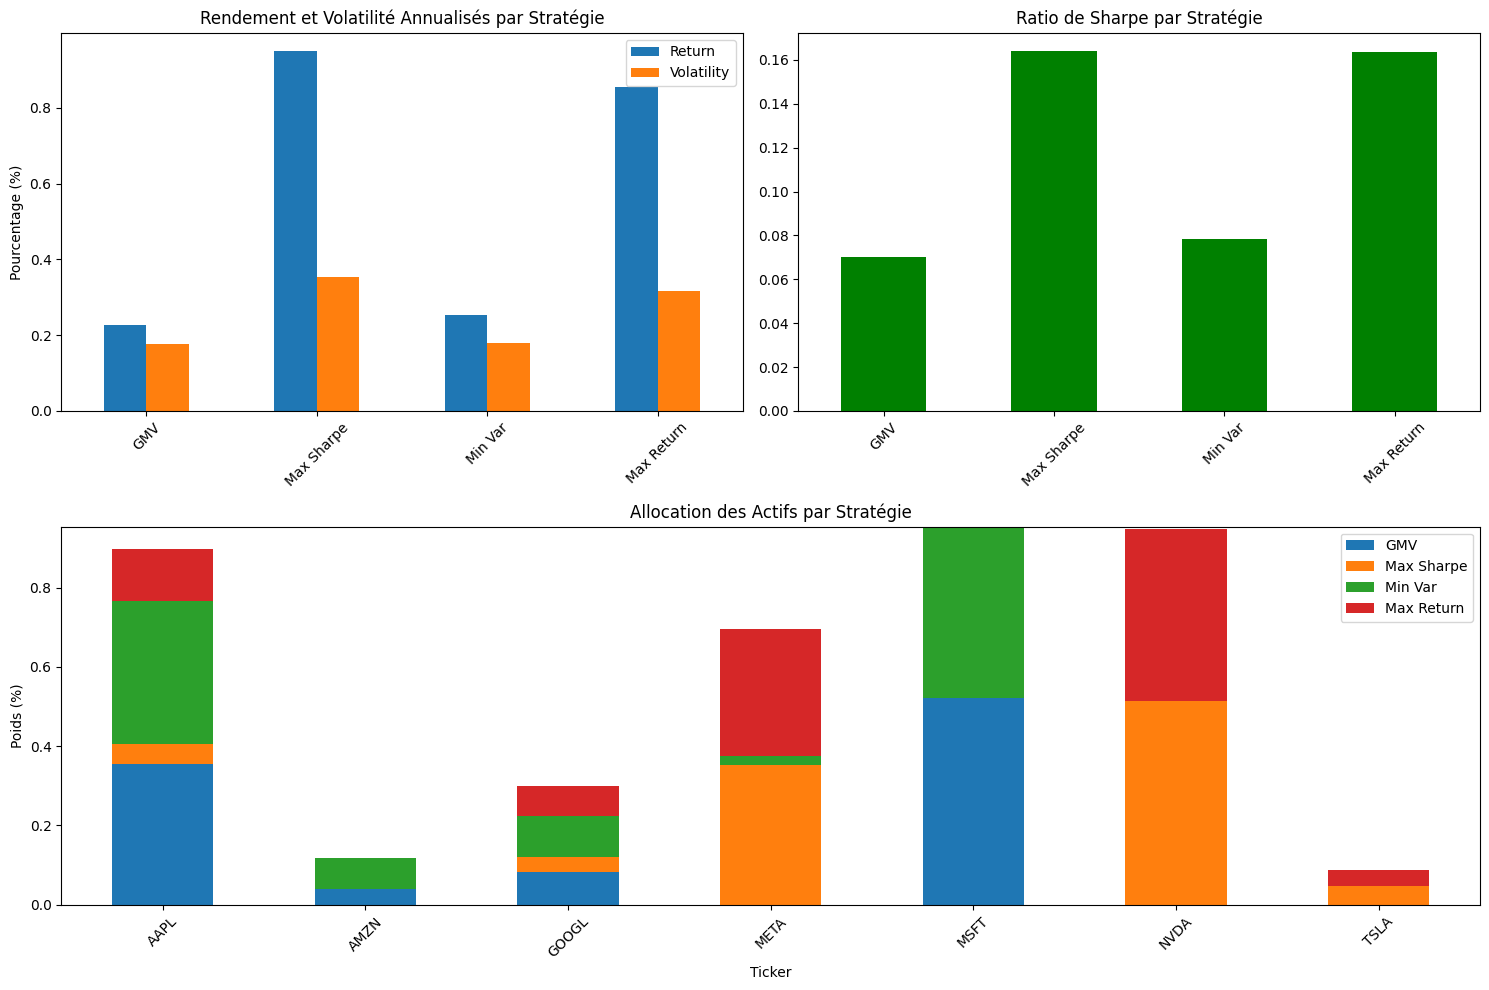


Métriques détaillées des portefeuilles:
            Return  Volatility  Sharpe Ratio
GMV         0.2279      0.1776        0.0703
Max Sharpe  0.9509      0.3536        0.1642
Min Var     0.2520      0.1784        0.0786
Max Return  0.8546      0.3175        0.1637

Allocations détaillées des portefeuilles:
           GMV  Max Sharpe  Min Var  Max Return
Ticker                                         
AAPL    0.3547      0.0495   0.3626      0.1311
AMZN    0.0406      0.0000   0.0781      0.0000
GOOGL   0.0838      0.0355   0.1041      0.0758
META   -0.0000      0.3535   0.0227      0.3200
MSFT    0.5209     -0.0000   0.4324      0.0000
NVDA   -0.0000      0.5141   0.0000      0.4337
TSLA    0.0000      0.0473   0.0000      0.0392


In [2]:

def main():
    # Paramètres configurables
    tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'NVDA', 'TSLA']
    target_return = 0.001  # 0.1%
    target_variance = 0.0004  # 0.04%
    risk_free_rate = 0.03  # 3% annuel
    
    # Création de l'optimiseur
    optimizer = PortfolioOptimizer(tickers, risk_free_rate=risk_free_rate)
    
    # Calcul des différents portefeuilles optimaux
    portfolio_results = {
        'GMV': optimizer.optimize_portfolio('gmv'),
        'Max Sharpe': optimizer.optimize_portfolio('max_sharpe'),
        'Min Var': optimizer.optimize_portfolio('min_var', target_return),
        'Max Return': optimizer.optimize_portfolio('max_return', target_variance)
    }
    
    # Affichage de la matrice de corrélation
    print("Affichage de la matrice de corrélation des actifs:")
    optimizer.plot_correlation_matrix()
    
    # Affichage de la frontière efficiente
    print("\nAffichage de la frontière efficiente:")
    optimizer.plot_efficient_frontier(target_return, target_variance)
    
    # Affichage des métriques des portefeuilles
    print("\nAffichage des métriques des portefeuilles:")
    optimizer.plot_portfolio_metrics(portfolio_results)

if __name__ == "__main__":
    main()

## CAPM

### Explication Détaillée du Code

1. **Importation des Bibliothèques**
   - **`yfinance`** : Pour télécharger les prix ajustés des actions à partir de Yahoo Finance.
   - **`pandas`** : Utilisé pour manipuler et analyser les données sous forme de tableaux (DataFrames).
   - **`numpy`** : Bibliothèque pour les opérations numériques, notamment les calculs mathématiques.
   - **`statsmodels.api`** : Fournit des outils pour l'estimation de modèles statistiques, en particulier les modèles de régression.
   - **`matplotlib.pyplot`** : Utilisé pour créer des visualisations graphiques des données.
   - **`pandas_datareader`** : Pour télécharger les données de recherche Fama-French via une API.

2. **Fonction `download_prices`**
   - **Objectif** : Télécharge les prix ajustés des actifs à partir de Yahoo Finance pour les tickers spécifiés dans une période donnée.
   - **Arguments** :
     - `tickers` : Liste de symboles boursiers.
     - `start_date` et `end_date` : Les dates de début et de fin pour le téléchargement des données.
   - **Retourne** : Un DataFrame contenant les prix ajustés.

3. **Téléchargement des Tickers et des Prix**
   - Une liste de tickers d'entreprises technologiques (AAPL, MSFT, GOOG, etc.) est définie.
   - Les prix ajustés sont téléchargés pour la période allant du 1er janvier 2020 au 1er janvier 2023.

4. **Calcul des Rendements Journaliers**
   - Les rendements journaliers sont calculés en utilisant la méthode `pct_change()` de pandas, qui donne le pourcentage de changement des prix d'un jour à l'autre.
   - Les valeurs `NaN` générées par le calcul de rendement (en raison de l'absence de valeur précédente) sont supprimées avec `dropna()`.

5. **Téléchargement des Facteurs Fama-French**
   - Les facteurs Fama-French sont téléchargés pour l'analyse du CAPM. Ces facteurs incluent le rendement du marché et le taux sans risque.
   - Les valeurs sont converties en rendements décimaux en divisant par 100.

6. **Alignement des Dates et Gestion des Fuseaux Horaires**
   - Les indices de temps des rendements et des facteurs Fama-French sont normalisés pour s'assurer qu'ils correspondent.
   - Les rendements et les facteurs sont restreints aux dates communes pour garantir la cohérence des données.

7. **Calcul des Rendements Excédentaires**
   - Les rendements excédentaires sont calculés en soustrayant le rendement sans risque des rendements journaliers, permettant d'évaluer la performance par rapport au risque.

8. **Modèles CAPM et Collecte des Résultats**
   - Une liste `capm_results` est initialisée pour stocker les résultats des modèles CAPM pour chaque actif.
   - Pour chaque ticker :
     - Les rendements excédentaires sont définis comme la variable dépendante `y`.
     - Le facteur de marché excédentaire (Mkt-RF) est utilisé comme variable indépendante `X`.
     - Un modèle de régression linéaire est ajusté pour estimer les paramètres alpha (rendement ajusté au risque) et beta (sensibilité au marché).
     - Les rendements attendus sont calculés en fonction du modèle CAPM.
     - Les résultats (ticker, alpha, beta, rendement attendu et rendement réalisé) sont ajoutés à la liste `capm_results`.

9. **Conversion des Résultats en DataFrame**
   - Les résultats sont convertis en DataFrame pour une présentation et une analyse faciles. Ce DataFrame contient des colonnes pour chaque métrique calculée.

10. **Affichage des Résultats du CAPM**
    - Les résultats sont affichés dans la console, montrant les alphas, les betas, les rendements attendus et réalisés pour chaque actif.

11. **Visualisation de la SML**
    - La SML est tracée pour visualiser la relation entre le beta et le rendement attendu des actifs.
    - Les rendements réalisés sont également affichés sous forme de points sur le graphique.
    - Les tickers sont annotés sur le graphique pour une identification facile.

12. **Affichage des Statistiques Descriptives**
    - Des statistiques descriptives (moyenne, écart-type, etc.) sont affichées pour les betas, les rendements attendus et les rendements réalisés, permettant d’évaluer la dispersion et la centralité de ces mesures.


[*********************100%***********************]  9 of 9 completed

Téléchargement des prix...
Téléchargement des facteurs Fama-French...



/var/folders/ss/jbz1nbvn0t75lsx8sk0v586m0000gn/T/ipykernel_7189/1809152832.py:25: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fama_french_data = web.DataReader('F-F_Research_Data_Factors_Daily', 'famafrench')[0]



Résultats du CAPM :
  Ticker   Alpha    Beta  Expected_Return  Realized_Return
0   AAPL  0.0006  1.1642           0.1061           0.2520
1   MSFT  0.0004  1.1402           0.1040           0.1976
2   GOOG  0.0002  1.0666           0.0977           0.1401
3   AMZN -0.0002  1.0029           0.0922           0.0295
4   META -0.0007  1.2330           0.1120          -0.0686
5   NVDA  0.0012  1.6603           0.1487           0.4490
6   TSLA  0.0024  1.5189           0.1366           0.7410
7   AVGO  0.0007  1.2665           0.1149           0.2945
8    LLY  0.0014  0.6155           0.0589           0.4082


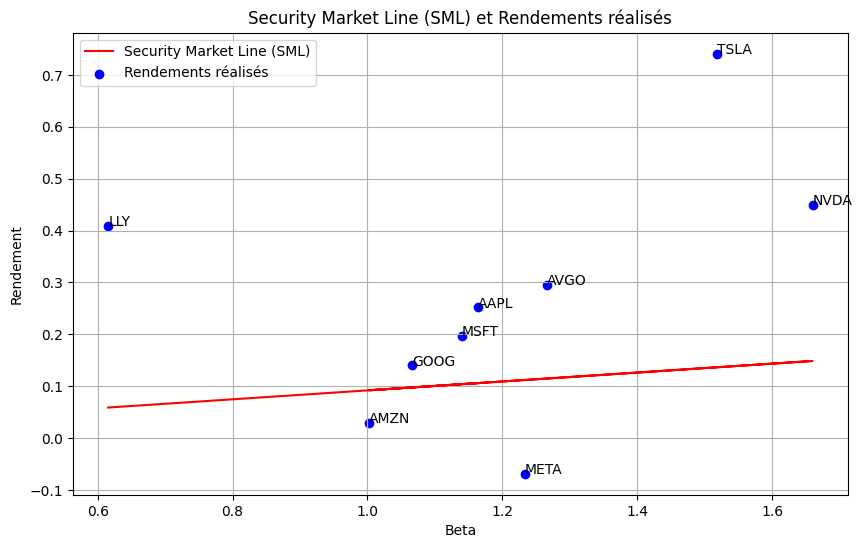


Statistiques descriptives des betas :
count    9.0000
mean     1.1853
std      0.3000
min      0.6155
25%      1.0666
50%      1.1642
75%      1.2665
max      1.6603
Name: Beta, dtype: float64

Statistiques descriptives des rendements attendus :
count    9.0000
mean     0.1079
std      0.0258
min      0.0589
25%      0.0977
50%      0.1061
75%      0.1149
max      0.1487
Name: Expected_Return, dtype: float64

Statistiques descriptives des rendements réalisés :
count    9.0000
mean     0.2715
std      0.2420
min     -0.0686
25%      0.1401
50%      0.2520
75%      0.4082
max      0.7410
Name: Realized_Return, dtype: float64


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas_datareader import data as web

# Fonction pour télécharger les prix ajustés
def download_prices(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

# Télécharger les tickers des entreprises
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA', 'AVGO', 'LLY']

# Télécharger les prix ajustés
print("Téléchargement des prix...")
prices = download_prices(tickers, start_date='2020-01-01', end_date='2023-01-01')

# Calcul des rendements journaliers
returns = prices.pct_change().dropna()

# Télécharger les facteurs Fama-French
print("Téléchargement des facteurs Fama-French...")
fama_french_data = web.DataReader('F-F_Research_Data_Factors_Daily', 'famafrench')[0]
fama_french_data = fama_french_data / 100  # Convertir en rendements décimaux

# Aligner les dates et gérer les fuseaux horaires
returns.index = pd.to_datetime(returns.index).tz_localize(None)
fama_french_data.index = pd.to_datetime(fama_french_data.index)
common_dates = returns.index.intersection(fama_french_data.index)
returns = returns.loc[common_dates]
fama_french_data = fama_french_data.loc[common_dates]

# Calcul des rendements excédentaires
rf = fama_french_data['RF']
rendements_excedentaires = returns.subtract(rf, axis=0)

# Modèles CAPM et collecte des résultats
capm_results = []
for ticker in tickers:
    if ticker in rendements_excedentaires.columns:
        y = rendements_excedentaires[ticker]
        X = fama_french_data['Mkt-RF']
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        beta = model.params['Mkt-RF']
        alpha = model.params['const']
        expected_return = rf.mean() * 252 + beta * (fama_french_data['Mkt-RF'].mean() * 252 - rf.mean() * 252)
        realized_return = y.mean() * 252
        capm_results.append({
            'Ticker': ticker,
            'Alpha': alpha,
            'Beta': beta,
            'Expected_Return': expected_return,
            'Realized_Return': realized_return
        })

# Convertir les résultats en DataFrame
capm_df = pd.DataFrame(capm_results)
print("\nRésultats du CAPM :")
print(capm_df.round(4))

# Tracer la SML
plt.figure(figsize=(10, 6))
plt.plot(capm_df['Beta'], capm_df['Expected_Return'], 'r-', label='Security Market Line (SML)')
plt.scatter(capm_df['Beta'], capm_df['Realized_Return'], c='blue', label='Rendements réalisés')

# Ajouter les labels des points
for i, ticker in enumerate(capm_df['Ticker']):
    plt.annotate(ticker, (capm_df['Beta'].iloc[i], capm_df['Realized_Return'].iloc[i]))

plt.xlabel('Beta')
plt.ylabel('Rendement')
plt.title('Security Market Line (SML) et Rendements réalisés')
plt.legend()
plt.grid(True)
plt.show()

# Afficher des statistiques supplémentaires
print("\nStatistiques descriptives des betas :")
print(capm_df['Beta'].describe().round(4))

print("\nStatistiques descriptives des rendements attendus :")
print(capm_df['Expected_Return'].describe().round(4))

print("\nStatistiques descriptives des rendements réalisés :")
print(capm_df['Realized_Return'].describe().round(4))

## APT 

### Explication Détaillée du Code

1. **Importation des Bibliothèques**
   - **`yfinance`** : Utilisé pour télécharger les prix ajustés des actions à partir de Yahoo Finance.
   - **`pandas`** : Bibliothèque principale pour la manipulation de données, facilitant l'analyse sous forme de tableaux (DataFrames).
   - **`numpy`** : Utilisé pour des opérations mathématiques et numériques.
   - **`statsmodels.api`** : Fournit des outils pour l'estimation de modèles statistiques, en particulier pour la régression linéaire.
   - **`matplotlib.pyplot`** : Utilisé pour créer des graphiques et des visualisations des résultats.
   - **`pandas_datareader`** : Permet de télécharger des données financières, comme les facteurs Fama-French, à partir de sources en ligne.

2. **Fonction `download_prices`**
   - **Objectif** : Télécharger les prix ajustés des actions pour une liste de tickers sur une période donnée.
   - **Arguments** :
     - `tickers` : Liste des symboles boursiers.
     - `start_date` et `end_date` : Dates de début et de fin pour le téléchargement des données.
   - **Retourne** : Un DataFrame contenant les prix ajustés des actions.

3. **Téléchargement des Tickers et des Prix**
   - Une liste de tickers d'entreprises (AAPL, MSFT, GOOG, etc.) est définie.
   - Les prix ajustés sont téléchargés pour la période allant du 1er janvier 2020 au 1er janvier 2023. Un message est affiché pour indiquer que le téléchargement des prix est en cours.

4. **Calcul des Rendements Journaliers**
   - Les rendements journaliers sont calculés en utilisant la méthode `pct_change()` de pandas, qui donne le pourcentage de changement des prix d'une journée à l'autre.
   - Les valeurs `NaN` (qui résultent de l'absence de valeur précédente) sont supprimées avec `dropna()`.

5. **Téléchargement des Facteurs Fama-French**
   - Les facteurs Fama-French à trois facteurs (marché, taille et valeur) sont téléchargés pour l'analyse. Ces facteurs sont essentiels pour évaluer la performance ajustée au risque des actifs.
   - Les valeurs sont converties en rendements décimaux en divisant par 100.

6. **Alignement des Dates et Gestion des Fuseaux Horaires**
   - Les indices de temps des rendements et des facteurs Fama-French sont normalisés pour s'assurer qu'ils correspondent.
   - Les rendements et les facteurs sont restreints aux dates communes pour garantir la cohérence des données.

7. **Calcul des Rendements Excédentaires**
   - Les rendements excédentaires sont calculés en soustrayant le rendement sans risque des rendements journaliers, ce qui permet d’évaluer la performance des actifs par rapport au risque pris.

8. **Modèle Fama-French à 3 Facteurs et Collecte des Résultats**
   - Une liste `ff3_results` est initialisée pour stocker les résultats du modèle Fama-French pour chaque actif.
   - Pour chaque ticker :
     - Les rendements excédentaires sont définis comme la variable dépendante `y`.
     - Les facteurs de marché (Mkt-RF), la taille (SMB) et la valeur (HML) sont utilisés comme variables indépendantes `X`.
     - Un modèle de régression linéaire est ajusté à l'aide de la méthode `OLS` de `statsmodels`.
     - Les coefficients (alpha et betas pour chaque facteur) sont extraits du modèle.
     - Les rendements attendus sont calculés à l'aide des coefficients estimés, en tenant compte des rendements moyens des facteurs.
     - Les rendements réalisés sont également calculés pour chaque actif.
     - Les résultats (ticker, alpha, betas, rendement attendu, rendement réalisé et statistiques du modèle) sont ajoutés à la liste `ff3_results`.

9. **Conversion des Résultats en DataFrame**
   - Les résultats sont convertis en un DataFrame pour une présentation et une analyse faciles. Ce DataFrame contient des colonnes pour chaque métrique calculée.

10. **Affichage des Résultats du Modèle Fama-French**
    - Les résultats du modèle sont affichés dans la console, montrant les alphas, les betas, les rendements attendus et réalisés pour chaque actif.

11. **Visualisation des Betas pour Chaque Facteur**
    - Un graphique à barres est créé pour visualiser les betas (sensibilité au marché, taille et valeur) pour chaque actif.
    - Trois sous-graphiques sont tracés pour représenter respectivement les betas MKT, SMB et HML.

12. **Comparaison des Rendements Attendus et Réalisés**
    - Un graphique à barres compare les rendements attendus et réalisés pour chaque actif. Cela aide à évaluer si les rendements réalisés sont conformes aux attentes basées sur le modèle Fama-French.

13. **Affichage des Statistiques Descriptives**
    - Des statistiques descriptives (moyenne, écart-type, etc.) sont affichées pour les betas et les rendements, permettant d’évaluer la dispersion et la centralité de ces mesures.
    - Les statistiques R² et R² ajusté sont également fournies, indiquant la qualité de l'ajustement du modèle.



[*********************100%***********************]  9 of 9 completed

Téléchargement des prix...
Téléchargement des facteurs Fama-French...



/var/folders/ss/jbz1nbvn0t75lsx8sk0v586m0000gn/T/ipykernel_7189/32635147.py:25: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fama_french_data = web.DataReader('F-F_Research_Data_Factors_Daily', 'famafrench')[0]



Résultats du modèle Fama-French à 3 facteurs :
  Ticker   Alpha  Beta_MKT  Beta_SMB  Beta_HML  Expected_Return  \
0   AAPL  0.0007    1.1951   -0.4162   -0.3830           0.0893   
1   MSFT  0.0005    1.1745   -0.4625   -0.4248           0.0845   
2   GOOG  0.0002    1.0827   -0.2548   -0.3164           0.0848   
3   AMZN -0.0001    1.0032   -0.2290   -0.7072           0.0566   
4   META -0.0006    1.2245   -0.1076   -0.5907           0.0850   
5   NVDA  0.0014    1.6202    0.0928   -0.9036           0.1072   
6   TSLA  0.0026    1.4044    0.8353   -0.7956           0.1037   
7   AVGO  0.0007    1.2392    0.2046   -0.1732           0.1135   
8    LLY  0.0014    0.6649   -0.4968   -0.0842           0.0556   

   Realized_Return  R_squared  Adj_R_squared  
0           0.2520     0.7416         0.7406  
1           0.1976     0.8244         0.8237  
2           0.1401     0.6992         0.6980  
3           0.0295     0.6002         0.5986  
4          -0.0686     0.5015         0.4995  

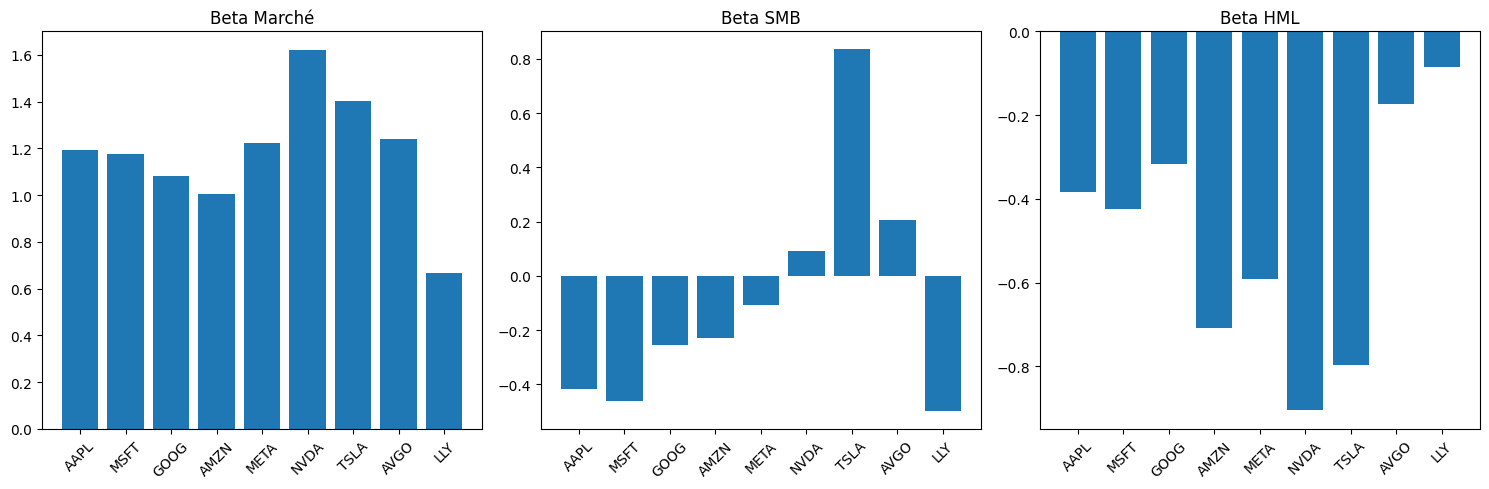

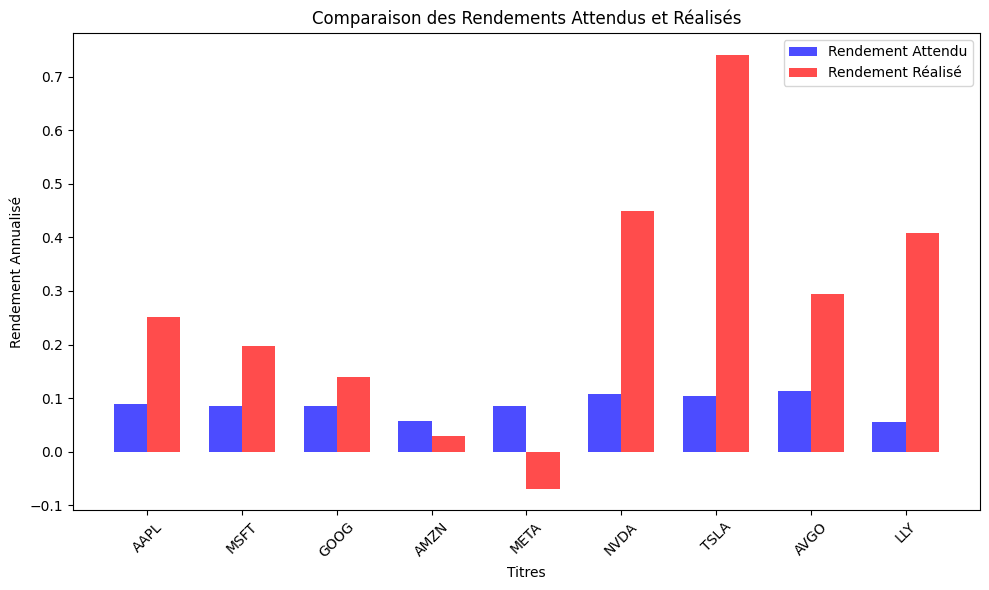


Statistiques descriptives des coefficients :

Beta Marché :
count    9.0000
mean     1.1787
std      0.2636
min      0.6649
25%      1.0827
50%      1.1951
75%      1.2392
max      1.6202
Name: Beta_MKT, dtype: float64

Beta SMB :
count    9.0000
mean    -0.0927
std      0.4233
min     -0.4968
25%     -0.4162
50%     -0.2290
75%      0.0928
max      0.8353
Name: Beta_SMB, dtype: float64

Beta HML :
count    9.0000
mean    -0.4865
std      0.2812
min     -0.9036
25%     -0.7072
50%     -0.4248
75%     -0.3164
max     -0.0842
Name: Beta_HML, dtype: float64

R² ajusté :
count    9.0000
mean     0.5983
std      0.1884
min      0.2489
25%      0.4995
50%      0.6862
75%      0.7141
max      0.8237
Name: Adj_R_squared, dtype: float64


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas_datareader import data as web

# Fonction pour télécharger les prix ajustés
def download_prices(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

# Télécharger les tickers des entreprises
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA', 'AVGO', 'LLY']

# Télécharger les prix ajustés
print("Téléchargement des prix...")
prices = download_prices(tickers, start_date='2020-01-01', end_date='2023-01-01')

# Calcul des rendements journaliers
returns = prices.pct_change().dropna()

# Télécharger les facteurs Fama-French
print("Téléchargement des facteurs Fama-French...")
fama_french_data = web.DataReader('F-F_Research_Data_Factors_Daily', 'famafrench')[0]
fama_french_data = fama_french_data / 100  # Convertir en rendements décimaux

# Aligner les dates et gérer les fuseaux horaires
returns.index = pd.to_datetime(returns.index).tz_localize(None)
fama_french_data.index = pd.to_datetime(fama_french_data.index)
common_dates = returns.index.intersection(fama_french_data.index)
returns = returns.loc[common_dates]
fama_french_data = fama_french_data.loc[common_dates]

# Calcul des rendements excédentaires
rf = fama_french_data['RF']
rendements_excedentaires = returns.subtract(rf, axis=0)

# Modèle Fama-French à 3 facteurs et collecte des résultats
ff3_results = []
for ticker in tickers:
    if ticker in rendements_excedentaires.columns:
        # Préparation des variables pour la régression
        y = rendements_excedentaires[ticker]
        X = fama_french_data[['Mkt-RF', 'SMB', 'HML']]
        X = sm.add_constant(X)
        
        # Estimation du modèle
        model = sm.OLS(y, X).fit()
        
        # Extraction des coefficients
        alpha = model.params['const']
        beta_mkt = model.params['Mkt-RF']
        beta_smb = model.params['SMB']
        beta_hml = model.params['HML']
        
        # Calcul des rendements attendus
        expected_return = (rf.mean() * 252 + 
                         beta_mkt * (fama_french_data['Mkt-RF'].mean() * 252) +
                         beta_smb * (fama_french_data['SMB'].mean() * 252) +
                         beta_hml * (fama_french_data['HML'].mean() * 252))
        
        realized_return = y.mean() * 252
        
        # Statistiques du modèle
        r_squared = model.rsquared
        adj_r_squared = model.rsquared_adj
        
        ff3_results.append({
            'Ticker': ticker,
            'Alpha': alpha,
            'Beta_MKT': beta_mkt,
            'Beta_SMB': beta_smb,
            'Beta_HML': beta_hml,
            'Expected_Return': expected_return,
            'Realized_Return': realized_return,
            'R_squared': r_squared,
            'Adj_R_squared': adj_r_squared
        })

# Convertir les résultats en DataFrame
ff3_df = pd.DataFrame(ff3_results)
print("\nRésultats du modèle Fama-French à 3 facteurs :")
print(ff3_df.round(4))

# Visualisation des betas pour chaque facteur
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Beta MKT
axes[0].bar(ff3_df['Ticker'], ff3_df['Beta_MKT'])
axes[0].set_title('Beta Marché')
axes[0].tick_params(axis='x', rotation=45)

# Beta SMB
axes[1].bar(ff3_df['Ticker'], ff3_df['Beta_SMB'])
axes[1].set_title('Beta SMB')
axes[1].tick_params(axis='x', rotation=45)

# Beta HML
axes[2].bar(ff3_df['Ticker'], ff3_df['Beta_HML'])
axes[2].set_title('Beta HML')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Comparaison Rendements Attendus vs Réalisés
plt.figure(figsize=(10, 6))
x = range(len(tickers))
width = 0.35

plt.bar([i - width/2 for i in x], ff3_df['Expected_Return'], width, label='Rendement Attendu', color='blue', alpha=0.7)
plt.bar([i + width/2 for i in x], ff3_df['Realized_Return'], width, label='Rendement Réalisé', color='red', alpha=0.7)

plt.xlabel('Titres')
plt.ylabel('Rendement Annualisé')
plt.title('Comparaison des Rendements Attendus et Réalisés')
plt.xticks(x, ff3_df['Ticker'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Statistiques descriptives
print("\nStatistiques descriptives des coefficients :")
print("\nBeta Marché :")
print(ff3_df['Beta_MKT'].describe().round(4))
print("\nBeta SMB :")
print(ff3_df['Beta_SMB'].describe().round(4))
print("\nBeta HML :")
print(ff3_df['Beta_HML'].describe().round(4))
print("\nR² ajusté :")
print(ff3_df['Adj_R_squared'].describe().round(4))

## Portefeuille - facteur cible 

### Explication Détaillée du Code

1. **Importation des Bibliothèques**
   - **`yfinance`** : Utilisé pour télécharger les prix ajustés des actions à partir de Yahoo Finance.
   - **`pandas`** : Fournit des structures de données flexibles pour la manipulation et l'analyse de données.
   - **`numpy`** : Bibliothèque utilisée pour des calculs numériques et des opérations sur des tableaux.
   - **`statsmodels.api`** : Fournit des outils pour l'estimation de modèles statistiques, en particulier la régression linéaire.
   - **`pandas_datareader`** : Permet de télécharger des données financières à partir de sources en ligne, y compris les facteurs Fama-French.
   - **`scipy.optimize`** : Contient des fonctions d'optimisation pour résoudre des problèmes d'optimisation, comme la minimisation d'une fonction objectif.
   - **`matplotlib.pyplot`** : Utilisé pour créer des graphiques et des visualisations des résultats.

2. **Fonction `download_prices`**
   - **Objectif** : Télécharger les prix ajustés des actifs pour une liste de tickers sur une période donnée.
   - **Arguments** :
     - `tickers` : Liste des symboles boursiers.
     - `start_date` et `end_date` : Dates de début et de fin pour le téléchargement des données.
   - **Retourne** : Un DataFrame contenant les prix ajustés des actions.

3. **Fonction `calculate_portfolio_betas`**
   - **Objectif** : Calculer les betas d'un portefeuille en fonction des poids des actifs, des rendements et des facteurs.
   - **Arguments** :
     - `weights` : Les poids des actifs dans le portefeuille.
     - `returns_data` : Les rendements des actifs.
     - `factors_data` : Les données des facteurs Fama-French.
   - **Retourne** : Un tableau contenant les betas pour le marché (Mkt-RF), SMB (Small Minus Big) et HML (High Minus Low).

4. **Fonction `objective_function`**
   - **Objectif** : Définir la fonction objectif pour l'optimisation.
   - **Arguments** :
     - `weights` : Les poids des actifs.
     - `returns_data` : Les rendements des actifs.
     - `factors_data` : Les données des facteurs.
     - `target_betas` : Les betas cibles que le portefeuille doit atteindre.
   - **Retourne** : La somme des carrés des écarts entre les betas du portefeuille et les betas cibles.

5. **Téléchargement des Données**
   - Une liste de tickers (AAPL, MSFT, GOOG, etc.) est définie.
   - Les prix ajustés sont téléchargés pour la période allant du 1er janvier 2020 au 1er janvier 2023. Un message est affiché pour indiquer que le téléchargement est en cours.

6. **Calcul des Rendements**
   - Les rendements journaliers sont calculés à partir des prix ajustés en utilisant la méthode `pct_change()` de pandas, et les valeurs `NaN` résultantes sont supprimées.

7. **Téléchargement des Facteurs Fama-French**
   - Les facteurs Fama-French sont téléchargés pour l'analyse. Ces facteurs incluent le rendement du marché, la taille et la valeur.
   - Les valeurs sont converties en rendements décimaux en divisant par 100.

8. **Alignement des Dates**
   - Les indices de temps des rendements et des facteurs Fama-French sont normalisés pour garantir qu'ils correspondent. 
   - Les rendements et les facteurs sont filtrés pour ne conserver que les dates communes.

9. **Calcul des Rendements Excédentaires**
   - Les rendements excédentaires sont calculés en soustrayant le rendement sans risque des rendements journaliers, ce qui permet d'évaluer la performance des actifs par rapport au risque pris.

10. **Définition des Betas Cibles**
    - Les betas cibles pour le modèle Fama-French sont définis sous forme de tableau : `[1.0, 0.2, 0.3]`, représentant les cibles pour le marché, SMB et HML, respectivement.

11. **Contraintes pour l'Optimisation**
    - Les contraintes sont définies pour s'assurer que la somme des poids est égale à 1 (100 % du portefeuille). 
    - Les bornes des poids sont également définies pour qu'ils restent entre 0 et 1 (pas de vente à découvert).

12. **Point de Départ pour l'Optimisation**
    - Un point de départ est défini avec des poids égaux pour tous les actifs.

13. **Optimisation**
    - La fonction `minimize` de `scipy.optimize` est utilisée pour trouver les poids optimaux qui minimisent la fonction objectif, en utilisant la méthode SLSQP (Sequential Least Squares Programming).
    - Les poids optimaux sont récupérés à partir du résultat de l'optimisation.

14. **Calcul des Betas du Portefeuille Optimisé**
    - Les betas du portefeuille optimisé sont calculés à l'aide des poids optimaux et des données de rendement et de facteurs.

15. **Création d'un DataFrame avec les Résultats**
    - Un DataFrame est créé pour afficher la composition du portefeuille optimisé, avec les tickers et les poids arrondis à quatre décimales.

16. **Affichage des Résultats**
    - La composition du portefeuille optimisé et les betas réalisés par rapport aux cibles sont affichés dans la console.

17. **Visualisation des Poids du Portefeuille**
    - Un graphique à barres est créé pour visualiser la composition du portefeuille optimisé.

18. **Visualisation des Betas Cibles vs Réalisés**
    - Un graphique à barres compare les betas cibles et réalisés pour chaque facteur, permettant une évaluation visuelle de l'atteinte des cibles.

19. **Calcul de la Performance du Portefeuille**
    - Les rendements du portefeuille sont calculés en utilisant les poids optimaux, et les rendements cumulés sont calculés en multipliant les rendements quotidiens.
    - Un graphique de performance cumulée est tracé pour montrer l'évolution de la valeur du portefeuille dans le temps.

20. **Statistiques de Performance**
    - Les statistiques de performance du portefeuille, telles que le rendement annualisé, la volatilité annualisée et le ratio de Sharpe, sont calculées et affichées dans la console.



[*********************100%***********************]  9 of 9 completed

Téléchargement des prix...
Téléchargement des facteurs Fama-French...



/var/folders/ss/jbz1nbvn0t75lsx8sk0v586m0000gn/T/ipykernel_7189/1531434778.py:37: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_factors = web.DataReader('F-F_Research_Data_Factors_Daily', 'famafrench')[0]



Composition du portefeuille optimisé :
  Ticker  Weight
0   AAPL  0.0000
1   MSFT  0.0000
2   GOOG  0.7798
3   AMZN  0.0000
4   META  0.2202
5   NVDA  0.0000
6   TSLA  0.0000
7   AVGO  0.0000
8    LLY  0.0000

Betas du portefeuille :
Beta Marché (cible: 1.0): 1.1127
Beta SMB (cible: 0.2): 0.0502
Beta HML (cible: 0.3): -0.1536


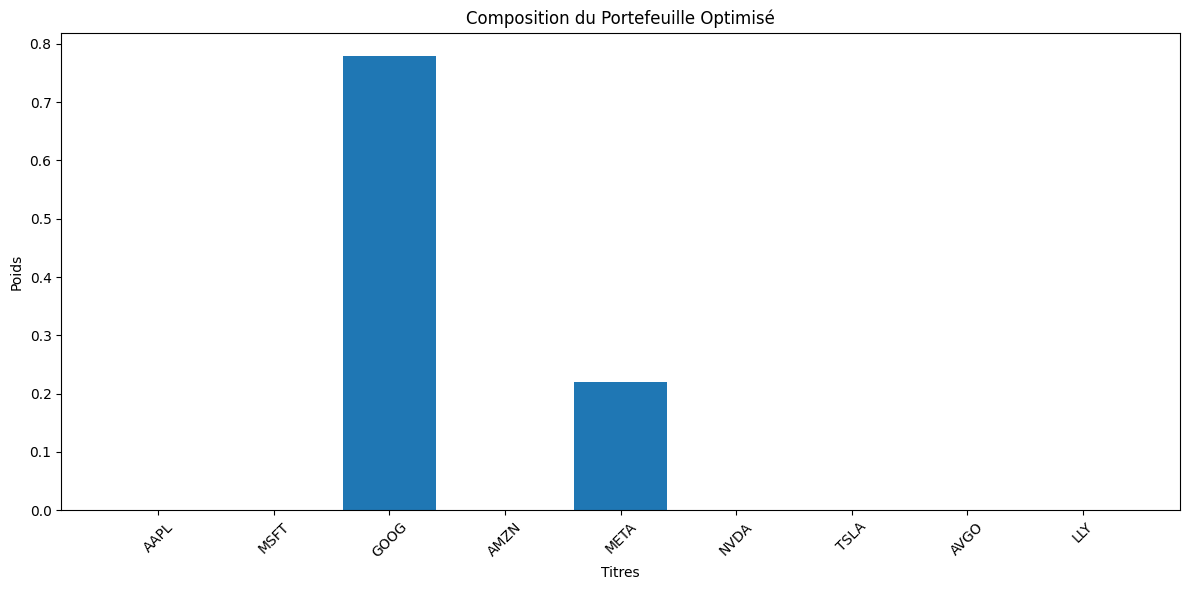

<Figure size 1000x600 with 0 Axes>

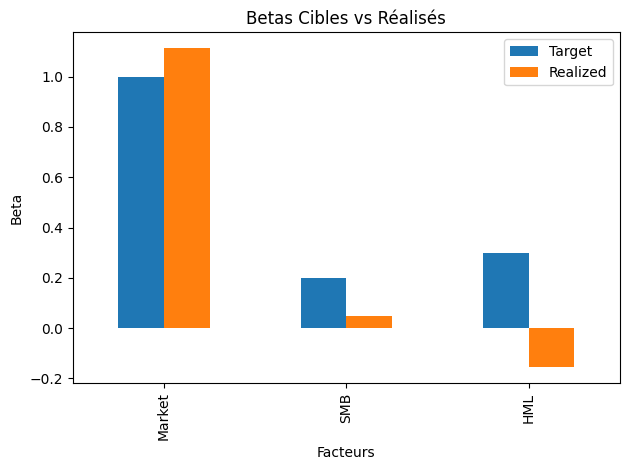

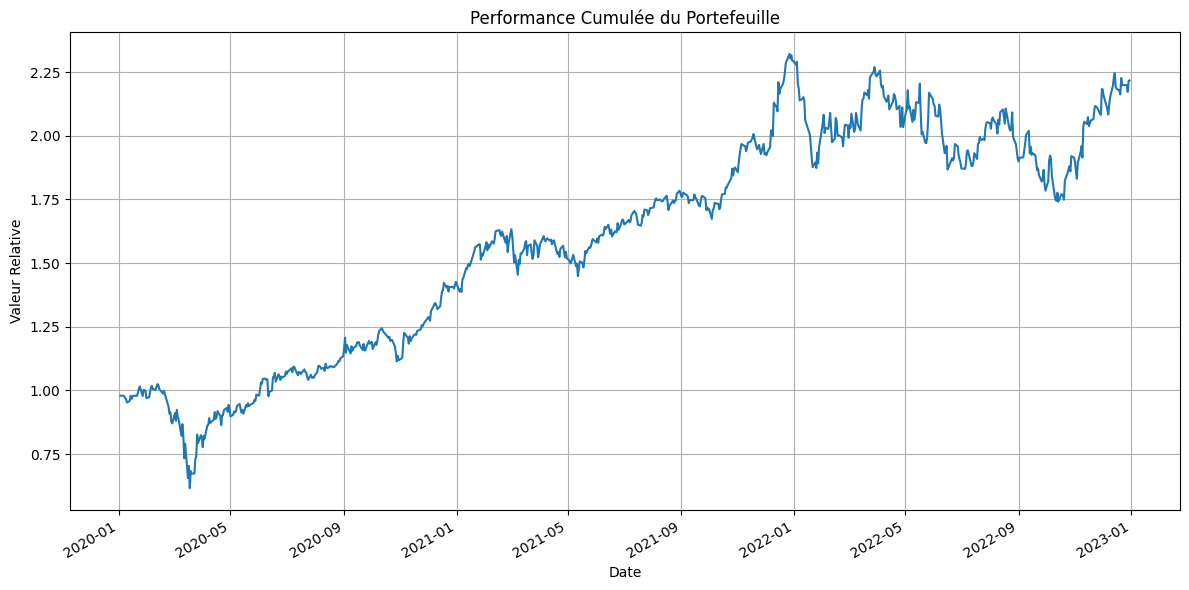


Statistiques de performance du portefeuille :
Rendement annualisé: 0.3256
Volatilité annualisée: 0.3438
Ratio de Sharpe: 0.9470


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pandas_datareader import data as web
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Fonction pour télécharger les prix ajustés
def download_prices(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

# Fonction pour calculer les betas du portefeuille
def calculate_portfolio_betas(weights, returns_data, factors_data):
    portfolio_returns = returns_data.dot(weights)
    X = factors_data[['Mkt-RF', 'SMB', 'HML']]
    X = sm.add_constant(X)
    model = sm.OLS(portfolio_returns, X).fit()
    return np.array([model.params['Mkt-RF'], model.params['SMB'], model.params['HML']])

# Fonction objectif pour l'optimisation
def objective_function(weights, returns_data, factors_data, target_betas):
    portfolio_betas = calculate_portfolio_betas(weights, returns_data, factors_data)
    return np.sum((portfolio_betas - target_betas)**2)

# Télécharger les données
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA', 'AVGO', 'LLY']
print("Téléchargement des prix...")
prices = download_prices(tickers, start_date='2020-01-01', end_date='2023-01-01')

# Calcul des rendements
returns = prices.pct_change().dropna()

# Télécharger les facteurs Fama-French
print("Téléchargement des facteurs Fama-French...")
ff_factors = web.DataReader('F-F_Research_Data_Factors_Daily', 'famafrench')[0]
ff_factors = ff_factors / 100

# Aligner les dates
returns.index = pd.to_datetime(returns.index).tz_localize(None)
ff_factors.index = pd.to_datetime(ff_factors.index)
common_dates = returns.index.intersection(ff_factors.index)
returns = returns.loc[common_dates]
ff_factors = ff_factors.loc[common_dates]

# Calcul des rendements excédentaires
rf = ff_factors['RF']
excess_returns = returns.subtract(rf, axis=0)

# Définir les betas cibles
target_betas = np.array([1.0, 0.2, 0.3])  # [Market, SMB, HML]

# Contraintes pour l'optimisation
constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # La somme des poids doit être égale à 1
]
bounds = tuple((0, 1) for _ in range(len(tickers)))  # Les poids doivent être entre 0 et 1

# Point de départ : poids égaux
initial_weights = np.array([1/len(tickers)] * len(tickers))

# Optimisation
result = minimize(
    objective_function,
    initial_weights,
    args=(excess_returns, ff_factors, target_betas),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimal_weights = result.x

# Calculer les betas du portefeuille optimisé
portfolio_betas = calculate_portfolio_betas(optimal_weights, excess_returns, ff_factors)

# Créer un DataFrame avec les résultats
portfolio_composition = pd.DataFrame({
    'Ticker': tickers,
    'Weight': optimal_weights
})
portfolio_composition['Weight'] = portfolio_composition['Weight'].round(4)

# Afficher les résultats
print("\nComposition du portefeuille optimisé :")
print(portfolio_composition)

print("\nBetas du portefeuille :")
print(f"Beta Marché (cible: {target_betas[0]}): {portfolio_betas[0]:.4f}")
print(f"Beta SMB (cible: {target_betas[1]}): {portfolio_betas[1]:.4f}")
print(f"Beta HML (cible: {target_betas[2]}): {portfolio_betas[2]:.4f}")

# Visualisation des poids du portefeuille
plt.figure(figsize=(12, 6))
plt.bar(tickers, optimal_weights)
plt.title('Composition du Portefeuille Optimisé')
plt.xlabel('Titres')
plt.ylabel('Poids')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualisation des betas cibles vs réalisés
beta_comparison = pd.DataFrame({
    'Target': target_betas,
    'Realized': portfolio_betas
}, index=['Market', 'SMB', 'HML'])

plt.figure(figsize=(10, 6))
beta_comparison.plot(kind='bar')
plt.title('Betas Cibles vs Réalisés')
plt.xlabel('Facteurs')
plt.ylabel('Beta')
plt.legend()
plt.tight_layout()
plt.show()

# Calculer la performance du portefeuille
portfolio_returns = returns.dot(optimal_weights)
cumulative_returns = (1 + portfolio_returns).cumprod()

plt.figure(figsize=(12, 6))
cumulative_returns.plot()
plt.title('Performance Cumulée du Portefeuille')
plt.xlabel('Date')
plt.ylabel('Valeur Relative')
plt.grid(True)
plt.tight_layout()
plt.show()

# Statistiques de performance
annual_return = portfolio_returns.mean() * 252
annual_volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_volatility

print("\nStatistiques de performance du portefeuille :")
print(f"Rendement annualisé: {annual_return:.4f}")
print(f"Volatilité annualisée: {annual_volatility:.4f}")
print(f"Ratio de Sharpe: {sharpe_ratio:.4f}")